In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Load the data
df = pd.read_csv('datasets/data.csv', sep=';', index_col='Row')
df

,Dim_0,Dim_1=0,Dim_2=0,Dim_3=0,Dim_4=0,Dim_5=0,Dim_6=0,Dim_7=0,Dim_8=0,Dim_9=0,...,Dim_13=0,Dim_14=0,Dim_15=0,Dim_16,Dim_17,Dim_18,Dim_19,Dim_20,Unnamed: 22,Unnamed: 23
Row,,,,,,,,,,,,,,,,,,,,,
0,"0,750000",1,0,1,1,1,1,1,0,1,...,1,1,1,"0,001132","0,080780","0,197324","0,300926","0,225000",NaN,NaN
1,"0,239583",1,1,1,1,1,1,1,1,1,...,1,1,1,"0,000472","0,164345","0,235786","0,537037","0,165625",NaN,NaN
2,"0,479167",1,1,1,1,1,1,1,1,1,...,1,1,1,"0,003585","0,130919","0,167224","0,527778","0,118750",NaN,NaN
3,"0,656250",0,1,1,1,1,1,1,1,1,...,1,1,1,"0,001698","0,091922","0,125418","0,337963","0,129688",NaN,NaN
4,"0,229167",1,1,1,1,1,1,1,1,1,...,1,1,1,"0,000472","0,142061","0,229097","0,337963","0,235938",NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7195,"0,604167",1,1,1,1,1,1,1,1,1,...,1,1,0,"0,004717","0,113092","0,128763","0,379630","0,121875",NaN,NaN
7196,"0,520833",1,1,1,1,1,1,1,1,1,...,1,1,1,"0,200000","0,030641","0,005017","0,333333","0,005469",NaN,NaN
7197,"0,520833",1,1,1,1,1,1,1,1,1,...,1,1,0,"0,001434","0,109192","0,147157","0,231481","0,206250",NaN,NaN


In [31]:
def PCA_tSNE_visualization(data2visualize, NCOMP, LABELS, PAL):

  '''
  INPUT
  data2visualize    - data matrix to visualize
  NCOMP             - no. of components to decompose the dataset during PCA
  LABELS            - labels given by the clustering solution
  PAL               - palette of colours to distinguish between clusters
  '''

  '''
  OUTPUT
  Two figures: one using PCA and one using tSNE
  '''


  # PCA
  from sklearn.decomposition import PCA
  pca = PCA(n_components=NCOMP)
  pca_result = pca.fit_transform(data2visualize)
  print('PCA: explained variation per principal component: {}'.format(pca.explained_variance_ratio_.round(2)))

  # tSNE
  from sklearn.manifold import TSNE
  print('\nApplying tSNE...')
  np.random.seed(100)
  tsne = TSNE(n_components=2, verbose=0, perplexity=20, n_iter=300)
  tsne_results = tsne.fit_transform(data2visualize)


  # Plots
  fig1000 = plt.figure(figsize=(10,5))
  fig1000.suptitle('Dimensionality reduction of the dataset', fontsize=16)


  # Plot 1: 2D image of the entire dataset
  ax1 = fig1000.add_subplot(121)
  sns.scatterplot(x=pca_result[:,0], y=pca_result[:,1], ax=ax1, hue=LABELS, palette=PAL)
  ax1.set_xlabel('Dimension 1', fontsize=10)
  ax1.set_ylabel('Dimension 2', fontsize=10)
  ax1.title.set_text('PCA')
  plt.grid()

  ax2= fig1000.add_subplot(122)
  sns.scatterplot(x=tsne_results[:,0], y=tsne_results[:,1], ax=ax2, hue=LABELS, palette=PAL)
  ax2.set_xlabel('Dimension 1', fontsize=10)
  ax2.set_ylabel('Dimension 2', fontsize=10)
  ax2.title.set_text('tSNE')
  plt.grid()
  plt.show()

# Data cleaning

In [32]:
# change the data type of the columns to float

df = df.replace(',', '.', regex=True).astype(float)
df.drop(['Unnamed: 22', 'Unnamed: 23'], axis=1, inplace=True)
df

,Dim_0,Dim_1=0,Dim_2=0,Dim_3=0,Dim_4=0,Dim_5=0,Dim_6=0,Dim_7=0,Dim_8=0,Dim_9=0,...,Dim_11=0,Dim_12=0,Dim_13=0,Dim_14=0,Dim_15=0,Dim_16,Dim_17,Dim_18,Dim_19,Dim_20
Row,,,,,,,,,,,,,,,,,,,,,
0,0.750000,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,...,1.0,1.0,1.0,1.0,1.0,0.001132,0.080780,0.197324,0.300926,0.225000
1,0.239583,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,0.000472,0.164345,0.235786,0.537037,0.165625
2,0.479167,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,0.003585,0.130919,0.167224,0.527778,0.118750
3,0.656250,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,0.001698,0.091922,0.125418,0.337963,0.129688
4,0.229167,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,0.000472,0.142061,0.229097,0.337963,0.235938
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7195,0.604167,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,0.0,0.004717,0.113092,0.128763,0.379630,0.121875
7196,0.520833,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,0.200000,0.030641,0.005017,0.333333,0.005469
7197,0.520833,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,0.0,0.001434,0.109192,0.147157,0.231481,0.206250


# Visualize the data after PCA and tSNE

PCA: explained variation per principal component: [0.31 0.16]

Applying tSNE...


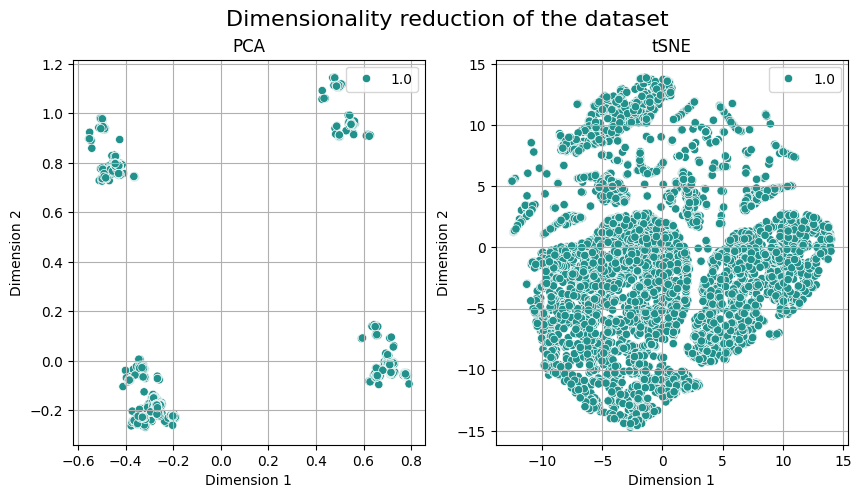

In [33]:
PCA_tSNE_visualization(df, 2, np.ones(df.shape[0]), 'viridis')